In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.default_dataset import DefaultDataset
from models.faster_vqa import FasterVQA

加载模型和权重

In [2]:
weight_path = '/home/ly/code/LinVQATools/faster_vqa/change_fc_loss/best_SROCC_epoch_105.pth'
weight = torch.load(weight_path)['state_dict']
model_dict = dict(backbone_size='swin_tiny_grpb',
    backbone={"fragments": dict(window_size=(4, 4, 4))},
    backbone_preserve_keys='fragments')
model = FasterVQA(**model_dict)
model.load_state_dict(weight)
print(model)

swin_tiny_grpb


/home/ly/anaconda3/envs/torch1.13/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


None False
Setting backbone: fragments_backbone
FasterVQA(
  (data_preprocessor): BaseDataPreprocessor()
  (model): DiViDeAddEvaluator(
    (fragments_backbone): SwinTransformer3D(
      (patch_embed): PatchEmbed3D(
        (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0): BasicLayer(
          (blocks): ModuleList(
            (0): SwinTransformerBlock3D(
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention3D(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (dro

加载验证集

In [3]:
dataset_dict = dict(anno_reader='ODVVQAReader',
        prefix='temp/fragment',
        phase='test',
        split_file='/home/ly/code/LinVQATools/data/odv_vqa/tr_te_VQA_ODV.txt',
        frame_sampler=dict(
            name='FragmentSampleFrames',
            fsize_t=32 // 8,
            fragments_t=8,
            clip_len=32,
            frame_interval=2,
            t_frag=8,
            num_clips=1,
        ),
        spatial_sampler=dict(
            name='PlaneSpatialFragmentSampler',
            fragments_h=7,
            fragments_w=7,
            fsize_h=32,
            fsize_w=32,
            aligned=8,
        ))
dataset = DefaultDataset(**dataset_dict)
dataloader = DataLoader(dataset=dataset,batch_size=1,num_workers=4,shuffle=False)

07/10 21:54:43 - mmengine - WARNING - anno_root参数未找到，默认为/home/ly/code/LinVQATools/data/odv_vqa


In [4]:
y = []
y_pred = []
model = model.cuda()
for item in tqdm(dataloader):
    inputs = item['inputs'].cuda()
    result = model(inputs,gt_label=item['gt_label'],mode='predict')
    y_pred.append(result[0])
    y.append(result[1])

  0%|          | 0/108 [00:00<?, ?it/s]

07/10 21:54:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1BikingToWork_ERP_3840x2160_fps23.976_qp27_12306k
07/10 21:54:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1BikingToWork_ERP_3840x2160_fps23.976_qp37_3596k
07/10 21:54:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1BikingToWork_RCMP_3840x2160_fps23.976_qp27_9939k_ERP
07/10 21:54:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1BikingToWork_ERP_3840x2160_fps23.976_qp42_1855k
07/10 21:54:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1BikingToWork_RCMP_3840x2160_fps23.976_qp37_2889k_ERP
07/10 21:54:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1BikingToWork_TSP_3840x2160_fps23.976_qp37_3252k_ERP
07/10 21:54:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1BikingToWork_TSP_3840x2160_fps23.976_qp27_10985k_ERP
07/10 21:54:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group

/home/ly/anaconda3/envs/torch1.13/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
  1%|          | 1/108 [00:03<06:25,  3.60s/it]

07/10 21:54:49 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_ERP_6144x3072_fps29.97_qp27_9229k
07/10 21:54:49 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_ERP_6144x3072_fps29.97_qp37_2048k


  3%|▎         | 3/108 [00:04<02:19,  1.33s/it]

07/10 21:54:50 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_ERP_6144x3072_fps29.97_qp42_880k


  4%|▎         | 4/108 [00:05<01:54,  1.11s/it]

07/10 21:54:51 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_RCMP_6144x3072_fps29.97_qp27_8296k_ERP


  5%|▍         | 5/108 [00:06<01:48,  1.05s/it]

07/10 21:54:52 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_RCMP_6144x3072_fps29.97_qp37_1961k_ERP


  6%|▌         | 6/108 [00:07<01:42,  1.00s/it]

07/10 21:54:53 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_RCMP_6144x3072_fps29.97_qp42_838k_ERP


  6%|▋         | 7/108 [00:08<01:35,  1.06it/s]

07/10 21:54:54 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_TSP_6144x3072_fps29.97_qp27_7639k_ERP


  7%|▋         | 8/108 [00:08<01:35,  1.05it/s]

07/10 21:54:55 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_TSP_6144x3072_fps29.97_qp37_1588k_ERP


  8%|▊         | 9/108 [00:09<01:32,  1.07it/s]

07/10 21:54:56 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group1/G1LandSalt_TSP_6144x3072_fps29.97_qp42_715k_ERP


  9%|▉         | 10/108 [00:10<01:29,  1.10it/s]

07/10 21:54:56 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_ERP_3840x1920_fps25_qp27_19131k


 10%|█         | 11/108 [00:11<01:30,  1.07it/s]

07/10 21:54:57 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_ERP_3840x1920_fps25_qp37_4153k


 11%|█         | 12/108 [00:12<01:28,  1.09it/s]

07/10 21:54:58 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_ERP_3840x1920_fps25_qp42_1608k


 12%|█▏        | 13/108 [00:13<01:25,  1.12it/s]

07/10 21:54:59 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_RCMP_3840x1920_fps25_qp27_15973k_ERP


 13%|█▎        | 14/108 [00:14<01:27,  1.07it/s]

07/10 21:55:00 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_RCMP_3840x1920_fps25_qp37_3521k_ERP


 14%|█▍        | 15/108 [00:15<01:24,  1.10it/s]

07/10 21:55:01 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_RCMP_3840x1920_fps25_qp42_1350k_ERP


 15%|█▍        | 16/108 [00:16<01:22,  1.12it/s]

07/10 21:55:02 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_TSP_3840x1920_fps25_qp27_20563k_ERP


 16%|█▌        | 17/108 [00:17<01:24,  1.08it/s]

07/10 21:55:03 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_TSP_3840x1920_fps25_qp37_5199k_ERP


 17%|█▋        | 18/108 [00:18<01:21,  1.10it/s]

07/10 21:55:04 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3BackcountrySkiing_TSP_3840x1920_fps25_qp42_2098k_ERP


 18%|█▊        | 19/108 [00:18<01:19,  1.12it/s]

07/10 21:55:05 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_ERP_3840x2160_fps29.97_qp27_12839k


 19%|█▊        | 20/108 [00:19<01:20,  1.09it/s]

07/10 21:55:06 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_ERP_3840x2160_fps29.97_qp37_3009k


 19%|█▉        | 21/108 [00:20<01:14,  1.17it/s]

07/10 21:55:06 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_ERP_3840x2160_fps29.97_qp42_1324k


 20%|██        | 22/108 [00:21<01:15,  1.14it/s]

07/10 21:55:07 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_RCMP_3840x2160_fps29.97_qp27_7602k_ERP


 21%|██▏       | 23/108 [00:22<01:15,  1.13it/s]

07/10 21:55:08 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_RCMP_3840x2160_fps29.97_qp37_1407k_ERP


 22%|██▏       | 24/108 [00:23<01:12,  1.15it/s]

07/10 21:55:09 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_RCMP_3840x2160_fps29.97_qp42_578k_ERP


 23%|██▎       | 25/108 [00:24<01:14,  1.11it/s]

07/10 21:55:10 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_TSP_3840x2160_fps29.97_qp27_7679k_ERP


 24%|██▍       | 26/108 [00:25<01:13,  1.11it/s]

07/10 21:55:11 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_TSP_3840x2160_fps29.97_qp37_1567k_ERP


 25%|██▌       | 27/108 [00:25<01:11,  1.13it/s]

07/10 21:55:12 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group3/G3SkyrimHelgen_TSP_3840x2160_fps29.97_qp42_674k_ERP


 26%|██▌       | 28/108 [00:26<01:12,  1.10it/s]

07/10 21:55:13 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_ERP_5600x2800_fps29.97_qp27_59876k


 27%|██▋       | 29/108 [00:27<01:08,  1.15it/s]

07/10 21:55:13 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_ERP_5600x2800_fps29.97_qp37_19310k


 28%|██▊       | 30/108 [00:28<01:08,  1.14it/s]

07/10 21:55:14 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_ERP_5600x2800_fps29.97_qp42_9360k


 29%|██▊       | 31/108 [00:29<01:09,  1.11it/s]

07/10 21:55:15 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_RCMP_5600x2800_fps29.97_qp27_51282k_ERP


 30%|██▉       | 32/108 [00:30<01:05,  1.16it/s]

07/10 21:55:16 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_RCMP_5600x2800_fps29.97_qp37_14076k_ERP


 31%|███       | 33/108 [00:31<01:06,  1.13it/s]

07/10 21:55:17 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_RCMP_5600x2800_fps29.97_qp42_6523k_ERP


 31%|███▏      | 34/108 [00:32<01:05,  1.13it/s]

07/10 21:55:18 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_TSP_5600x2800_fps29.97_qp27_49345k_ERP


 32%|███▏      | 35/108 [00:32<01:03,  1.15it/s]

07/10 21:55:19 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_TSP_5600x2800_fps29.97_qp37_14570k_ERP


 33%|███▎      | 36/108 [00:33<01:04,  1.11it/s]

07/10 21:55:20 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4BikingInSaalbach_TSP_5600x2800_fps29.97_qp42_7056k_ERP


 34%|███▍      | 37/108 [00:34<01:02,  1.13it/s]

07/10 21:55:21 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_ERP_3840x2160_fps29.97_qp27_15115k


 35%|███▌      | 38/108 [00:35<01:01,  1.14it/s]

07/10 21:55:21 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_ERP_3840x2160_fps29.97_qp37_4266k


 36%|███▌      | 39/108 [00:36<01:02,  1.10it/s]

07/10 21:55:22 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_ERP_3840x2160_fps29.97_qp42_2186k


 37%|███▋      | 40/108 [00:37<00:57,  1.18it/s]

07/10 21:55:23 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_RCMP_3840x2160_fps29.97_qp27_16373k_ERP


 38%|███▊      | 41/108 [00:38<00:58,  1.15it/s]

07/10 21:55:24 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_RCMP_3840x2160_fps29.97_qp37_4116k_ERP


 39%|███▉      | 42/108 [00:39<00:58,  1.14it/s]

07/10 21:55:25 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_RCMP_3840x2160_fps29.97_qp42_2077k_ERP


 40%|███▉      | 43/108 [00:40<00:56,  1.15it/s]

07/10 21:55:26 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_TSP_3840x2160_fps29.97_qp27_18647k_ERP


 41%|████      | 44/108 [00:40<00:57,  1.12it/s]

07/10 21:55:27 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_TSP_3840x2160_fps29.97_qp37_5244k_ERP


 42%|████▏     | 45/108 [00:41<00:56,  1.12it/s]

07/10 21:55:28 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4DrewBrees_TSP_3840x2160_fps29.97_qp42_2695k_ERP


 43%|████▎     | 46/108 [00:42<00:54,  1.14it/s]

07/10 21:55:28 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_ERP_3840x2048_fps29.97_qp27_12696k


 44%|████▎     | 47/108 [00:43<00:55,  1.09it/s]

07/10 21:55:29 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_ERP_3840x2048_fps29.97_qp37_3545k


 44%|████▍     | 48/108 [00:44<00:54,  1.10it/s]

07/10 21:55:30 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_ERP_3840x2048_fps29.97_qp42_1877k


 45%|████▌     | 49/108 [00:45<00:52,  1.13it/s]

07/10 21:55:31 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_RCMP_3840x2048_fps29.97_qp27_10195k_ERP


 46%|████▋     | 50/108 [00:46<00:53,  1.08it/s]

07/10 21:55:32 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_RCMP_3840x2048_fps29.97_qp37_2600k_ERP


 47%|████▋     | 51/108 [00:47<00:50,  1.13it/s]

07/10 21:55:33 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_RCMP_3840x2048_fps29.97_qp42_1341k_ERP


 48%|████▊     | 52/108 [00:48<00:49,  1.13it/s]

07/10 21:55:34 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_TSP_3840x2048_fps29.97_qp27_9198k_ERP


 49%|████▉     | 53/108 [00:49<00:50,  1.09it/s]

07/10 21:55:35 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_TSP_3840x2048_fps29.97_qp37_2378k_ERP


 50%|█████     | 54/108 [00:49<00:46,  1.16it/s]

07/10 21:55:36 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group4/G4WingsuitFlight_TSP_3840x2048_fps29.97_qp42_1226k_ERP


 51%|█████     | 55/108 [00:50<00:46,  1.14it/s]

07/10 21:55:36 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_ERP_3840x1920_fps29.97_qp27_19898k


 52%|█████▏    | 56/108 [00:51<00:46,  1.13it/s]

07/10 21:55:37 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_ERP_3840x1920_fps29.97_qp37_3644k


 53%|█████▎    | 57/108 [00:52<00:44,  1.15it/s]

07/10 21:55:38 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_ERP_3840x1920_fps29.97_qp42_1484k


 54%|█████▎    | 58/108 [00:53<00:44,  1.11it/s]

07/10 21:55:39 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_RCMP_3840x1920_fps29.97_qp27_19645k_ERP


 55%|█████▍    | 59/108 [00:54<00:43,  1.12it/s]

07/10 21:55:40 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_RCMP_3840x1920_fps29.97_qp37_3568k_ERP


 56%|█████▌    | 60/108 [00:55<00:42,  1.14it/s]

07/10 21:55:41 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_RCMP_3840x1920_fps29.97_qp42_1492k_ERP


 56%|█████▋    | 61/108 [00:56<00:43,  1.09it/s]

07/10 21:55:42 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_TSP_3840x1920_fps29.97_qp27_21576k_ERP


 57%|█████▋    | 62/108 [00:56<00:40,  1.14it/s]

07/10 21:55:43 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_TSP_3840x1920_fps29.97_qp37_4476k_ERP


 58%|█████▊    | 63/108 [00:57<00:39,  1.14it/s]

07/10 21:55:44 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group5/G5ResistMarch_TSP_3840x1920_fps29.97_qp42_1840k_ERP


 59%|█████▉    | 64/108 [00:58<00:39,  1.11it/s]

07/10 21:55:45 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_ERP_7680x3840_fps29.97_qp27_54581k


 60%|██████    | 65/108 [00:59<00:37,  1.16it/s]

07/10 21:55:45 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_ERP_7680x3840_fps29.97_qp37_5981k


 61%|██████    | 66/108 [01:00<00:37,  1.13it/s]

07/10 21:55:46 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_ERP_7680x3840_fps29.97_qp42_1663k


 62%|██████▏   | 67/108 [01:01<00:36,  1.13it/s]

07/10 21:55:47 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_RCMP_7680x3840_fps29.97_qp27_38041k_ERP


 63%|██████▎   | 68/108 [01:02<00:34,  1.15it/s]

07/10 21:55:48 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_RCMP_7680x3840_fps29.97_qp37_3582k_ERP


 64%|██████▍   | 69/108 [01:03<00:35,  1.11it/s]

07/10 21:55:49 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_RCMP_7680x3840_fps29.97_qp42_1306k_ERP


 65%|██████▍   | 70/108 [01:04<00:34,  1.11it/s]

07/10 21:55:50 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_TSP_7680x3840_fps29.97_qp27_29114k_ERP


 66%|██████▌   | 71/108 [01:04<00:32,  1.13it/s]

07/10 21:55:51 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_TSP_7680x3840_fps29.97_qp37_3561k_ERP


 67%|██████▋   | 72/108 [01:05<00:33,  1.09it/s]

07/10 21:55:52 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group6/G6AngelFallsClimbing_TSP_7680x3840_fps29.97_qp42_1480k_ERP


 68%|██████▊   | 73/108 [01:06<00:31,  1.11it/s]

07/10 21:55:53 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_ERP_4096x2048_fps30_qp27_4909k


 69%|██████▊   | 74/108 [01:07<00:30,  1.13it/s]

07/10 21:55:53 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_ERP_4096x2048_fps30_qp37_1038k


 69%|██████▉   | 75/108 [01:08<00:30,  1.09it/s]

07/10 21:55:54 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_ERP_4096x2048_fps30_qp42_509k


 70%|███████   | 76/108 [01:09<00:27,  1.17it/s]

07/10 21:55:55 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_RCMP_4096x2048_fps30_qp27_4286k_ERP


 71%|███████▏  | 77/108 [01:10<00:27,  1.15it/s]

07/10 21:55:56 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_RCMP_4096x2048_fps30_qp37_980k_ERP


 72%|███████▏  | 78/108 [01:11<00:26,  1.13it/s]

07/10 21:55:57 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_RCMP_4096x2048_fps30_qp42_485k_ERP


 73%|███████▎  | 79/108 [01:12<00:25,  1.15it/s]

07/10 21:55:58 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_TSP_4096x2048_fps30_qp27_5525k_ERP


 74%|███████▍  | 80/108 [01:12<00:24,  1.12it/s]

07/10 21:55:59 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_TSP_4096x2048_fps30_qp37_1238k_ERP


 75%|███████▌  | 81/108 [01:13<00:24,  1.12it/s]

07/10 21:56:00 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7PressConference_TSP_4096x2048_fps30_qp42_635k_ERP


 76%|███████▌  | 82/108 [01:14<00:22,  1.14it/s]

07/10 21:56:00 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_ERP_4096x2048_fps30_qp27_4387k


 77%|███████▋  | 83/108 [01:15<00:22,  1.10it/s]

07/10 21:56:01 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_ERP_4096x2048_fps30_qp37_880k


 78%|███████▊  | 84/108 [01:16<00:21,  1.13it/s]

07/10 21:56:02 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_ERP_4096x2048_fps30_qp42_294k


 79%|███████▊  | 85/108 [01:17<00:20,  1.13it/s]

07/10 21:56:03 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_RCMP_4096x2048_fps30_qp27_3965k_ERP


 80%|███████▉  | 86/108 [01:18<00:20,  1.10it/s]

07/10 21:56:04 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_RCMP_4096x2048_fps30_qp37_961k_ERP


 81%|████████  | 87/108 [01:19<00:17,  1.17it/s]

07/10 21:56:05 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_RCMP_4096x2048_fps30_qp42_353k_ERP


 81%|████████▏ | 88/108 [01:20<00:17,  1.13it/s]

07/10 21:56:06 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_TSP_4096x2048_fps30_qp27_7770k_ERP


 82%|████████▏ | 89/108 [01:20<00:16,  1.12it/s]

07/10 21:56:07 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_TSP_4096x2048_fps30_qp37_1963k_ERP


 83%|████████▎ | 90/108 [01:21<00:15,  1.15it/s]

07/10 21:56:08 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group7/G7Shooting_TSP_4096x2048_fps30_qp42_906k_ERP


 84%|████████▍ | 91/108 [01:22<00:15,  1.12it/s]

07/10 21:56:08 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_ERP_7680x3840_fps29.97_qp27_12254k


 85%|████████▌ | 92/108 [01:23<00:14,  1.13it/s]

07/10 21:56:09 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_ERP_7680x3840_fps29.97_qp37_1499k


 86%|████████▌ | 93/108 [01:24<00:13,  1.15it/s]

07/10 21:56:10 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_ERP_7680x3840_fps29.97_qp42_1044k


 87%|████████▋ | 94/108 [01:25<00:12,  1.11it/s]

07/10 21:56:11 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_RCMP_7680x3840_fps29.97_qp27_11238k_ERP


 88%|████████▊ | 95/108 [01:26<00:11,  1.17it/s]

07/10 21:56:12 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_RCMP_7680x3840_fps29.97_qp37_1390k_ERP


 89%|████████▉ | 96/108 [01:27<00:10,  1.14it/s]

07/10 21:56:13 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_RCMP_7680x3840_fps29.97_qp42_901k_ERP


 90%|████████▉ | 97/108 [01:28<00:09,  1.12it/s]

07/10 21:56:14 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_TSP_7680x3840_fps29.97_qp27_16522k_ERP


 91%|█████████ | 98/108 [01:28<00:08,  1.15it/s]

07/10 21:56:15 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_TSP_7680x3840_fps29.97_qp37_2799k_ERP


 92%|█████████▏| 99/108 [01:29<00:08,  1.12it/s]

07/10 21:56:15 - mmengine - INFO - 尝试加载/data/ly/temp/fragment/0/VQA_ODV/Group10/G10PandaBaseChengdu_TSP_7680x3840_fps29.97_qp42_1196k_ERP


100%|██████████| 108/108 [01:37<00:00,  1.10it/s]


In [5]:
from scipy.stats import spearmanr

y_pred = torch.stack(y_pred,dim=0).flatten().cpu().detach().numpy()
y = torch.stack(y,dim=0).flatten().numpy()
s = spearmanr(y, y_pred)[0]
print(s)

0.8789429058656529


In [6]:
print(y)
print(y_pred)
print(y-y_pred)

[0.51132804 0.5121804  0.3778674  0.5966643  0.52622783 0.38351288
 0.5757952  0.55957365 0.4351227  0.6646226  0.5567569  0.29488623
 0.6628805  0.522985   0.25827035 0.62213933 0.5569207  0.32290414
 0.5357787  0.47965592 0.32013595 0.5746439  0.46648276 0.3666844
 0.5680887  0.5283015  0.47307777 0.57668144 0.49099138 0.3588439
 0.5733949  0.45492408 0.28146625 0.5985142  0.46595427 0.2991815
 0.56138104 0.50505793 0.44462454 0.53615963 0.44455922 0.44559354
 0.56366974 0.4463708  0.48651758 0.58086497 0.5357705  0.4452538
 0.61498195 0.5618573  0.4033826  0.5898661  0.61411136 0.50728554
 0.5738605  0.59103864 0.4383474  0.573973   0.51360047 0.44698453
 0.62682134 0.5736339  0.46532336 0.6036083  0.48774067 0.35964543
 0.61667264 0.4382963  0.26264408 0.62269986 0.5554357  0.4467364
 0.63419855 0.5647622  0.30006748 0.6116221  0.5409302  0.20384605
 0.646545   0.5678368  0.24719436 0.55914426 0.40730527 0.2633503
 0.60309356 0.388904   0.26027983 0.62979597 0.4799649  0.3261121
 0

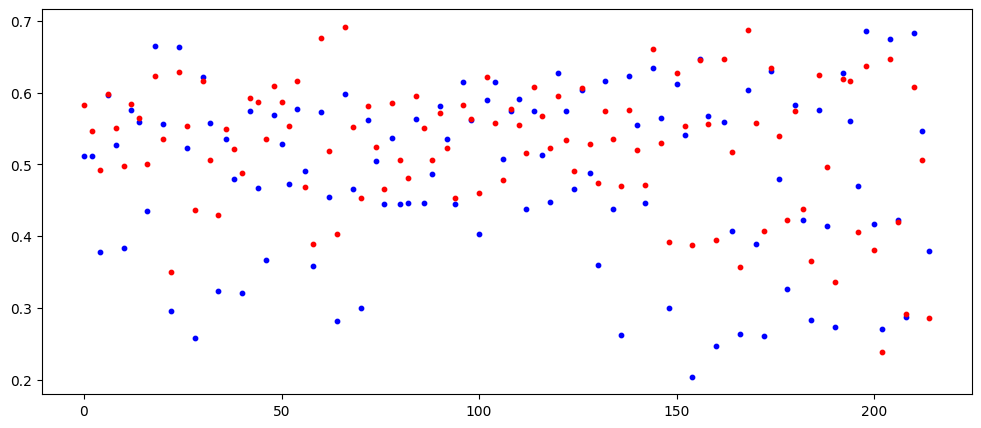

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
plt.scatter(x=[i for i in range(0,2*len(y),2)],y=y,c='b',s=10)
plt.scatter(x=[i for i in range(0,2*len(y_pred),2)],y=y_pred,c='r',s=10)